In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 414 (delta 136), reused 116 (delta 75), pack-reused 171
Receiving objects: 100% (414/414), 69.42 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=7c3cdee4bf33fe4189584a3f8000bd9a42d521993793cc074ea62883f1562281
  Stored in directory: /tmp/pip-ephem-wheel-cache-ru8ozsty/wheels/55/59/29/0fb1c635652

In [2]:
from dul_2021.utils.hw10_utils import *

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.optim import Adam
import numpy as np
from torchvision.transforms.functional import rotate

from tqdm.notebook import tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
class Encoder(nn.Module):
  def __init__(self, latent_dim, const):
    super().__init__()
    self.latent_dim = latent_dim
    self.const = const

    self.seq = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                              nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1),
                              nn.ReLU(), 
                              nn.Conv2d(64, 128, 3, 2, 1), 
                              nn.ReLU(), 
                              nn.Conv2d(128, 128, 3, 2, 1), 
                              nn.ReLU())
    self.linear = nn.Linear(self.const, self.latent_dim)    
  def forward(self, data):
    data = self.seq(data).flatten(start_dim=1)
    output = self.linear(data)
    return output

class Decoder(nn.Module):
  def __init__(self, latent_dim, const):
    super().__init__()
    self.latent_dim = latent_dim
    self.const = const

    self.seq = nn.Sequential(nn.ConvTranspose2d(128, 128, 3, 2, 1), 
                              nn.ReLU(), 
                              nn.ConvTranspose2d(128, 64, 4, 2, 1), 
                              nn.ReLU(), 
                              nn.ConvTranspose2d(64, 32, 4, 2, 1), 
                              nn.ReLU(), 
                              nn.Conv2d(32, 1, 3, 1, 1),
                              nn.Tanh())
    self.linaer = nn.Sequential(nn.Linear(self.latent_dim, self.const),
                                nn.ReLU())
  def forward(self, data):
    data = self.linaer(data)
    data = data.view(-1, 128, 4, 4)
    output = self.seq(data)
    return output

class D(nn.Module):
  def __init__(self, hidden_dim, const): 
    super().__init__()
    self.hidden_dim = hidden_dim
    self.const = const
    self.seq = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                              nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1),
                              nn.ReLU(), 
                              nn.Conv2d(64, 128, 3, 2, 1), 
                              nn.ReLU(), 
                              nn.Conv2d(128, 128, 3, 2, 1), 
                              nn.ReLU())
    self.linear = nn.Sequential(nn.Linear(self.const, self.hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(self.hidden_dim, self.hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(self.hidden_dim, 1),
                                nn.Sigmoid())
  def forward(self, data):
    data = self.seq(data).flatten(start_dim=1)
    output = self.linear(data)
    return output 
    

In [6]:
class Context_Encoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, const):
    super().__init__()
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim
    self.const = const
    self.encoder = Encoder(self.latent_dim, self.const)
    self.decoder = Decoder(self.latent_dim, self.const)
    self.d = D(self.hidden_dim, self.const)
  
  def creat_mask(self, data, height=14, width=14):
    size = data.shape[0]
    h, w = data.shape[2], data.shape[3]

    init_mask = torch.zeros_like(data)
    diff_h = int(h - height)
    diff_w = int(w - width)
    random_h = np.full(size, diff_h // 2)
    random_w = np.full(size, diff_w // 2)
    
    for m, h, w in zip(init_mask, random_h, random_w):
      m[:, h:h+height, w:w+width] = 1   
    return init_mask

  def forward(self, data):
    data = self.encoder(data)
    output = self.decoder(data)
    return output

  def get_loss(self, data):
    data = data.to(device)
    size = data.shape[0]
    mask = self.creat_mask(data)
    mask = mask.to(device)
    x = (1 - mask) * data
    recon_data = self.forward(x)
    recon_data_copy = recon_data.clone().detach()

    loss_record = mask * F.mse_loss(data, recon_data, reduction='none')
    loss_record = loss_record.reshape(size, -1).mean(1)
    loss_record = loss_record.mean()

    d_real = self.d(data)
    ones_real = torch.ones_like(d_real)
    loss_real = F.binary_cross_entropy(d_real, ones_real)

    d_fake_1 = self.d(recon_data)    
    ones_fake = torch.ones_like(d_fake_1)
    loss_fake_1 = F.binary_cross_entropy(d_fake_1, ones_fake)

    loss_rec_desc = loss_record + loss_fake_1
    loss_rec_desc = loss_rec_desc.mean()

    d_fake_2 = self.d(recon_data_copy)
    zeroes_fake = torch.zeros_like(d_fake_2)
    loss_fake_2 = F.binary_cross_entropy(d_fake_2, zeroes_fake)

    loss_adversarial = loss_real + loss_fake_2
    loss_adversarial = loss_adversarial.mean()

    return loss_record, loss_adversarial, loss_rec_desc

  def fit(self, train_data, lr, epochs):
    self.train()
    mse_losses, adversarial_losses = [], []
    list_params_encoder = list(self.encoder.parameters())
    list_params_decoder = list(self.decoder.parameters())
    optim_e_d = Adam(list_params_encoder + list_params_decoder, lr=lr)
    optim_disc = Adam(self.d.parameters(), lr=lr)    

    i = 1
    for epoch in tqdm(range(epochs)):
      for batch in train_data:
        batch = batch.to(device)
        loss_record, loss_adversarial, loss_rec_desc = self.get_loss(batch)

        optim_e_d.zero_grad()
        loss_rec_desc.backward()
        optim_e_d.step()

        if (i + 1) % 10 == 0:
          optim_disc.zero_grad()
          loss_adversarial.backward()
          optim_disc.step()
        i += 1

        mse_losses.append(loss_record.item())
        adversarial_losses.append(loss_adversarial.item())

    mse_losses = np.array(mse_losses) 
    adversarial_losses = np.array(adversarial_losses)
    return mse_losses, adversarial_losses

  def get_reconstructions(self, sample_data):
    with torch.no_grad():
      data = sample_data.data.unsqueeze(1)
      data = 2.0 * (data / 255.0) - 1.0
      len_data = len(data)
      part_data = data[np.random.choice(len_data, size=10, replace=False)]
      self.eval()
      data = torch.tensor(part_data)
      data = data.to(device)
      mask = self.creat_mask(data)
      mask = mask.to(device)
      x = (1 - mask) * data
      data_forward = self.forward(x)

      removed_central_region = x.cpu().numpy()
      reconstracted_images = data_forward.cpu().numpy()
      initial = data.cpu().numpy()
      
      combo = np.vstack((removed_central_region, reconstracted_images, initial))
    return combo
    

In [7]:
params = {'latent_dim': 128 ,
          'hidden_dim': 128,
          'batch_size': 128,
          'num_epochs': 10,
          'lr': 1e-3,
          'const': 4 * 4 * 128}
          

In [8]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    train = train_data.data.unsqueeze(1) 
    train = 2.0 * (train / 255.0) - 1.0
    train = DataLoader(train,
                       batch_size=params['batch_size'],
                       shuffle=True)
    
    model_CE = Context_Encoder(latent_dim=params['latent_dim'],
                               hidden_dim=params['hidden_dim'],
                               const=params['const'])
    model_CE = model_CE.to(device)
    print('done with init')
    mse_losses, adversarial_losses = model_CE.fit(train_data=train, 
                                                  lr=params['lr'], 
                                                  epochs=params['num_epochs'])
    print('done with losses')
    reconstructions = model_CE.get_reconstructions(test_data)
    print('done with reconstruction')
    return mse_losses, adversarial_losses, reconstructions
    

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

done with init


  0%|          | 0/10 [00:00<?, ?it/s]

done with losses
done with reconstruction


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


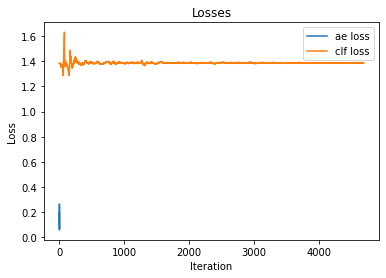

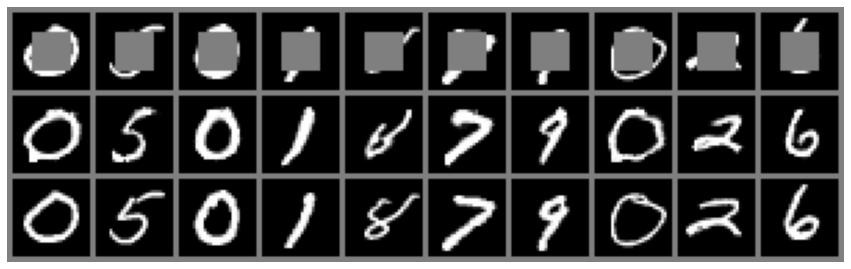

In [9]:
q1_results(q1)


# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [10]:
class Classification(nn.Module):
  def __init__(self, hidden_dim, num_classes):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    
    self.seq = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                              nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1),
                              nn.ReLU(), 
                              nn.Conv2d(64, 128, 3, 2, 1), 
                              nn.ReLU(), 
                              nn.Conv2d(128, 128, 3, 2, 1), 
                              nn.ReLU())
    self.linear = nn.Sequential(nn.Linear(4 * 4 * 128, self.hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(self.hidden_dim, self.hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(self.hidden_dim, self.num_classes))
  def forward(self, data):
    size = data.shape[0]
    output = self.seq(data)
    output = output.flatten(start_dim=1)
    output = self.linear(output)
    return output


In [11]:
class Rotations_Prediction(nn.Module):
  def __init__(self, hidden_dim, num_classes):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    self.classifier = Classification(self.hidden_dim, self.num_classes)

  def fit(self, train_data, num_epochs, lr):
    self.train()    
    optimizer = Adam(self.parameters(), lr=lr)
    loss_per_batch, accuracy_score = [], []

    for epoch in tqdm(range(num_epochs)):
      n = 0
      acc = 0
      for batch, target in train_data:
        batch = batch.to(device)
        size = batch.shape[0]
        n += size

        target = target.to(device)
        target_hat = self.classifier(batch)

        current_loss = F.cross_entropy(target_hat, target)
        current_loss = current_loss.mean()
        current_accuracy = (torch.argmax(target_hat, 1) == target).sum()
        acc += current_accuracy.item()

        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()

        loss_per_batch.append(current_loss.item())  
        
      score = acc / n
      accuracy_score.append(score)

    loss_per_batch = np.array(loss_per_batch)
    accuracy_score = np.array(accuracy_score)

    return loss_per_batch, accuracy_score


In [12]:
class Dataset_for_Rotations_Prediction(Dataset):
  def __init__(self, data, angles):
    super().__init__()
    self.data = data
    self.angles = angles

  def __getitem__(self, id):
    count_angles = len(self.angles)
    random_angle = np.random.randint(0, count_angles)
    choose_angle = self.angles[random_angle]
    data_with_angle = rotate(self.data[id][0], choose_angle)
    return data_with_angle, random_angle

  def __len__(self):
    length = len(self.data)
    return length


In [13]:
params = {'latent_dim': 128,
          'hidden_dim': 128,
          'num_epochs': 10,
          'num_classes': 4,
          'lr': 1e-3,
          'angles': (0, 90, 180, 270),
          'batch_size': 256}
          

In [14]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """
    train = Dataset_for_Rotations_Prediction(data=train_data, 
                                             angles=params['angles'])
    train = DataLoader(train,
                       batch_size=params['batch_size'],
                       shuffle=True)
    model_RP = Rotations_Prediction(hidden_dim=params['hidden_dim'], 
                                    num_classes=params['num_classes'])
    model_RP = model_RP.to(device)
    print('done with init')
    loss_per_batch, accuracy_score = model_RP.fit(train, 
                                                  num_epochs=params['num_epochs'], 
                                                  lr=params['lr'])
    print('done with losses and accuracy')
    return loss_per_batch, accuracy_score
    

done with init


  0%|          | 0/10 [00:00<?, ?it/s]

done with losses and accuracy


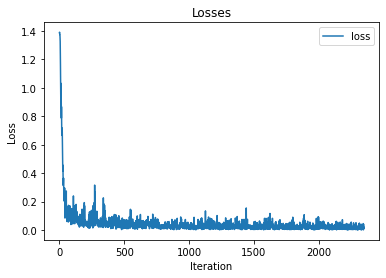

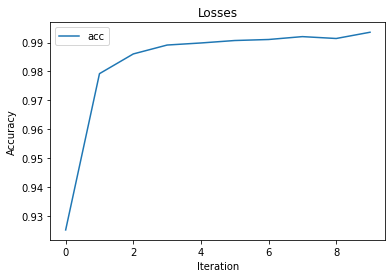

In [15]:
q2_results(q2)
